In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load EuroSAT RGB with splits
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,       # returns (image,label)
    with_info=True
)
class_names = ds_info.features['label'].names  # 10 class names
num_classes = ds_info.features['label'].num_classes
print(f"Classes ({num_classes}): {class_names}")


2025-06-16 16:01:32.445652: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-16 16:01:32.832245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750089692.989327   48193 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750089693.028121   48193 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750089693.343882   48193 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Classes (10): ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)
    # ResNet50 preprocessing (zero-center, RGB→BGR)
    image = tf.keras.applications.resnet.preprocess_input(image)
    label = tf.one_hot(label, depth=num_classes)  # categorical labels
    return image, label

train_ds = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1024).batch(batch_size).prefetch(AUTOTUNE)
val_ds   = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
test_ds  = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)


In [3]:
from keras import layers, models

base_model = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze base

# Add custom classification head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']  # include accuracy as primary metric
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15


2025-06-16 16:01:54.943924: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1750089715.342738   48566 service.cc:152] XLA service 0x7f4884013070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750089715.342791   48566 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-06-16 16:01:55.512963: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750089717.937217   48566 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-16 16:01:59.895542: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5599', 36 bytes spill stores, 44 bytes spill

648/675 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6796 - loss: 0.9751

2025-06-16 16:02:55.001578: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1731', 4 bytes spill stores, 4 bytes spill loads

2025-06-16 16:03:03.812125: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 12 bytes spill stores, 12 bytes spill loads

2025-06-16 16:03:03.814358: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 8 bytes spill stores, 8 bytes spill loads

2025-06-16 16:03:04.207483: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1724', 112 bytes spill stores, 112 bytes spill loads

2025-06-16 16:03:04.743187: I external/loc

675/675 ━━━━━━━━━━━━━━━━━━━━ 80s 89ms/step - accuracy: 0.6857 - loss: 0.9568 - val_accuracy: 0.9426 - val_loss: 0.1708
Epoch 2/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 48s 70ms/step - accuracy: 0.9264 - loss: 0.2315 - val_accuracy: 0.9533 - val_loss: 0.1350
Epoch 3/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - accuracy: 0.9431 - loss: 0.1739 - val_accuracy: 0.9600 - val_loss: 0.1174
Epoch 4/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - accuracy: 0.9512 - loss: 0.1425 - val_accuracy: 0.9637 - val_loss: 0.1067
Epoch 5/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 49s 72ms/step - accuracy: 0.9577 - loss: 0.1245 - val_accuracy: 0.9648 - val_loss: 0.1011
Epoch 6/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 49s 72ms/step - accuracy: 0.9638 - loss: 0.1109 - val_accuracy: 0.9637 - val_loss: 0.1004
Epoch 7/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - accuracy: 0.9670 - loss: 0.0972 - val_accuracy: 0.9630 - val_loss: 0.0979
Epoch 8/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - accuracy: 0.9729 - loss: 0.0801 - val_accurac

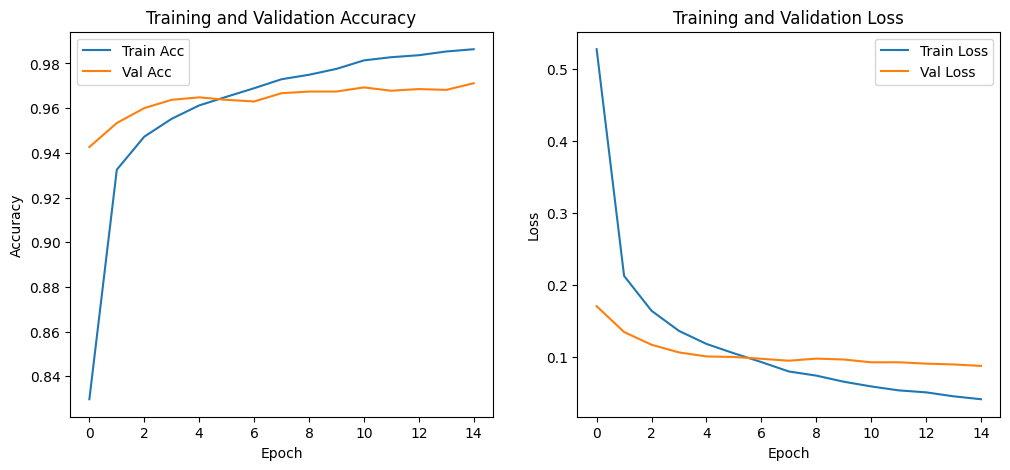

In [4]:
epochs = 15
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

import matplotlib.pyplot as plt

acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Training and Validation Loss')
plt.show()


In [5]:
from keras.callbacks import ModelCheckpoint

# Create ModelCheckpoint callback
checkpoint_cb = ModelCheckpoint(
    'ResNet_best_model.h5',           # File to save
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,       # Save only the best model
    save_weights_only=False,   # Save full model (not just weights)
    mode='max',                # Maximize val_accuracy
    verbose=1                  # Print when model is saved
)
# Unfreeze some top layers
base_model.trainable = True
for layer in base_model.layers[:-10]:  # freeze all layers except last 10
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
fine_tune_epochs = 15
history_ft = model.fit(
    train_ds,
    epochs=epochs+fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    callbacks=[checkpoint_cb]
)


Epoch 15/30


2025-06-16 16:14:46.920765: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6224', 12 bytes spill stores, 16 bytes spill loads

2025-06-16 16:14:47.117745: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6224', 4 bytes spill stores, 4 bytes spill loads



675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9820 - loss: 0.0537
Epoch 15: val_accuracy improved from -inf to 0.96741, saving model to ResNet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 74s 87ms/step - accuracy: 0.9820 - loss: 0.0537 - val_accuracy: 0.9674 - val_loss: 0.0934
Epoch 16/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9895 - loss: 0.0341
Epoch 16: val_accuracy improved from 0.96741 to 0.96889, saving model to ResNet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.9895 - loss: 0.0341 - val_accuracy: 0.9689 - val_loss: 0.0945
Epoch 17/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9931 - loss: 0.0254
Epoch 17: val_accuracy did not improve from 0.96889
675/675 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/step - accuracy: 0.9931 - loss: 0.0254 - val_accuracy: 0.9678 - val_loss: 0.0917
Epoch 18/30
663/675 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9958 - loss: 0.0209
Epoch 18: val_accuracy did not improve from 0.96889
675/675 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/step - accuracy: 0.9958 - loss: 0.0209 - val_accuracy: 0.9685 - val_loss: 0.0904
Epoch 19/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9958 - loss: 0.0177
Epoch 19: val_accuracy improved from 0.96889 to 0.97037, saving model to ResNet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.9958 - loss: 0.0177 - val_accuracy: 0.9704 - val_loss: 0.0933
Epoch 20/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9972 - loss: 0.0146
Epoch 20: val_accuracy improved from 0.97037 to 0.97185, saving model to ResNet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.9972 - loss: 0.0146 - val_accuracy: 0.9719 - val_loss: 0.0930
Epoch 21/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9979 - loss: 0.0117
Epoch 21: val_accuracy did not improve from 0.97185
675/675 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/step - accuracy: 0.9979 - loss: 0.0117 - val_accuracy: 0.9707 - val_loss: 0.0925
Epoch 22/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9981 - loss: 0.0099
Epoch 22: val_accuracy did not improve from 0.97185
675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - accuracy: 0.9981 - loss: 0.0099 - val_accuracy: 0.9715 - val_loss: 0.0938
Epoch 23/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9989 - loss: 0.0075
Epoch 23: val_accuracy improved from 0.97185 to 0.97370, saving model to ResNet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 52s 76ms/step - accuracy: 0.9989 - loss: 0.0075 - val_accuracy: 0.9737 - val_loss: 0.0945
Epoch 24/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9990 - loss: 0.0068
Epoch 24: val_accuracy did not improve from 0.97370
675/675 ━━━━━━━━━━━━━━━━━━━━ 50s 74ms/step - accuracy: 0.9990 - loss: 0.0068 - val_accuracy: 0.9696 - val_loss: 0.1004
Epoch 25/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9988 - loss: 0.0063
Epoch 25: val_accuracy did not improve from 0.97370
675/675 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/step - accuracy: 0.9988 - loss: 0.0063 - val_accuracy: 0.9707 - val_loss: 0.1011
Epoch 26/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9993 - loss: 0.0054
Epoch 26: val_accuracy did not improve from 0.97370
675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - accuracy: 0.9993 - loss: 0.0054 - val_accuracy: 0.9722 - val_loss: 0.1006
Epoch 27/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9992 - loss: 0.0051
Epoch 27: val_ac

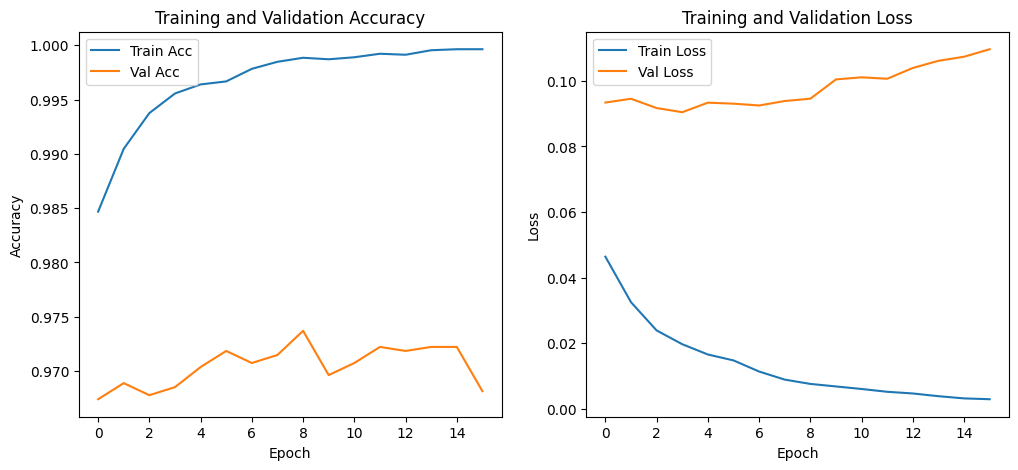

In [8]:
import matplotlib.pyplot as plt

acc      = history_ft.history['accuracy']
val_acc  = history_ft.history['val_accuracy']
loss     = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Training and Validation Loss')
plt.show()

85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9739 - loss: 0.0949

✅ Test Accuracy: 97.15%
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step


2025-06-16 16:29:05.803276: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


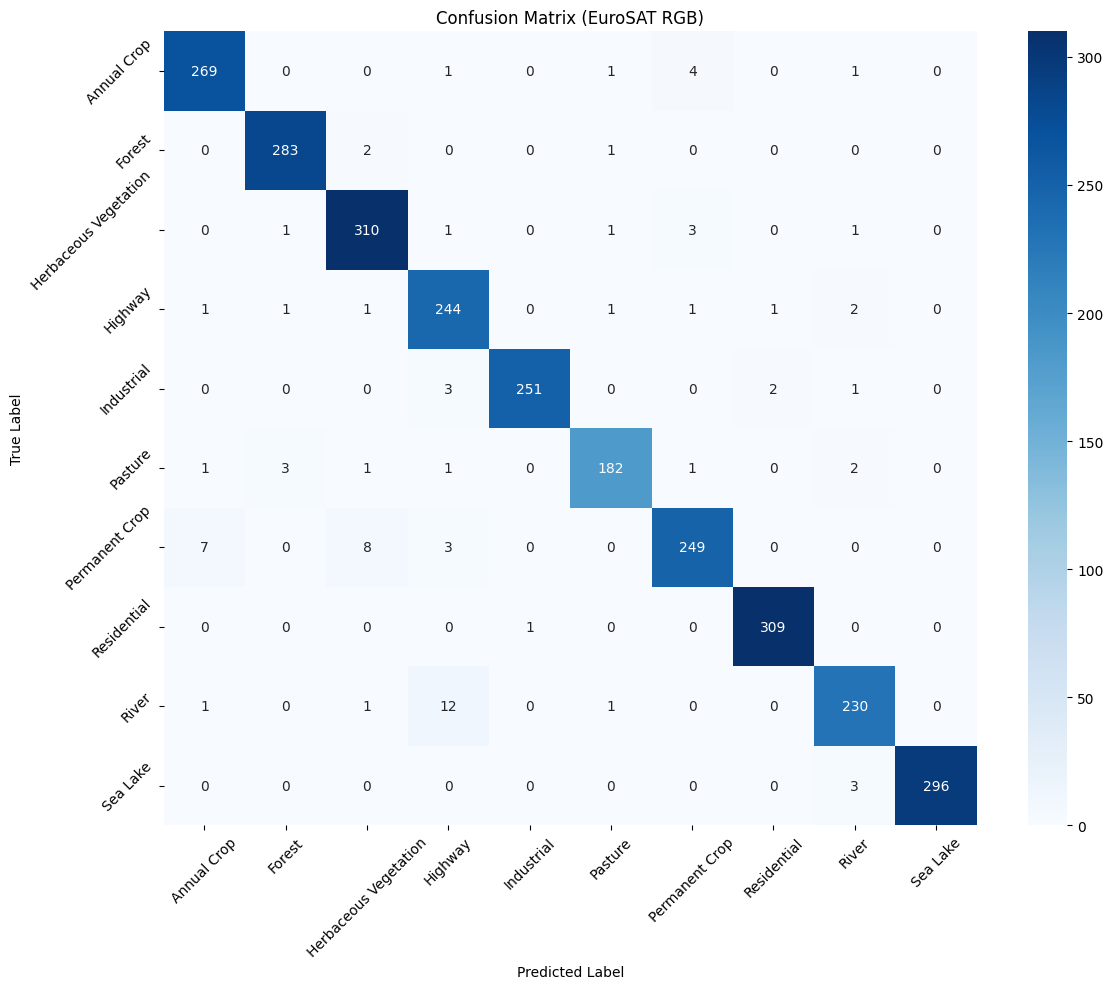

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Evaluate model and print accuracy
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")

# 2. Predict class labels
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Extract true labels from dataset
y_true = []
for _, labels in test_ds:
    labels = tf.convert_to_tensor(labels)
    if len(labels.shape) > 1 and labels.shape[-1] > 1:
        labels = tf.argmax(labels, axis=1)
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

# 4. Ensure both arrays are 1D integer class labels
y_true = y_true.astype(int)
y_pred = y_pred.astype(int)

# 5. Define class names (EuroSAT RGB has 10 classes)
class_names = [
    'Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial',
    'Pasture', 'Permanent Crop', 'Residential', 'River', 'Sea Lake'
]

# 6. Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 7. Plot heatmap with class labels
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (EuroSAT RGB)')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


2025-06-16 16:29:06.877627: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


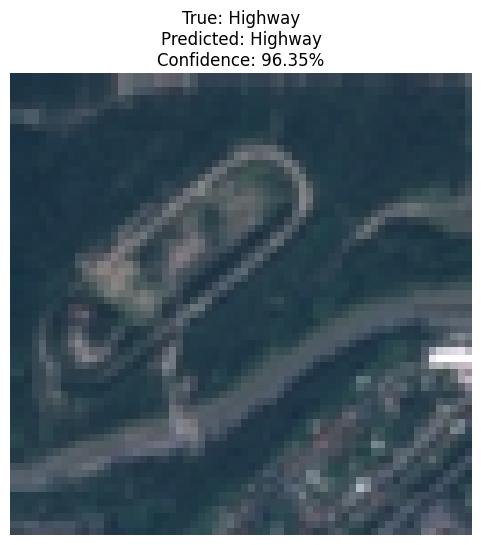

✅ Predicted class: Highway
✅ True class: Highway
✅ Confidence score: 96.35%


In [7]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Unbatch the test dataset to pick individual images
unbatched_test = ds_test.take(1000)  # Adjust limit as needed

# Convert dataset to a list of (image, label) tuples
test_images = list(unbatched_test)

# Select a random image and label
image, true_label = random.choice(test_images)

# Prepare image for model prediction (apply same preprocessing as during training)
def preprocess_for_prediction(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return image

# Apply preprocessing and add batch dimension
input_image = tf.expand_dims(preprocess_for_prediction(image), axis=0)

# Get model prediction
pred_probs = model.predict(input_image)
pred_class = tf.argmax(pred_probs[0]).numpy()
confidence_score = tf.reduce_max(pred_probs[0]).numpy()

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f"True: {class_names[true_label]}\nPredicted: {class_names[pred_class]}\nConfidence: {confidence_score:.2%}")
plt.axis('off')
plt.show()

# Print prediction and accuracy
print(f"✅ Predicted class: {class_names[pred_class]}")
print(f"✅ True class: {class_names[true_label]}")
print(f"✅ Confidence score: {confidence_score:.2%}")